# Proyecciones de mapas y datos ráster

En esta sección, veremos ejemplos de cómo reproyectar conjuntos de datos ráster y cómo trabajar con transformaciones de coordenadas con GDAL. Nos centraremos en estas operaciones comunes.

1. Conversión de coordenadas de un sistema de proyección a otro
2. Reproyección de rásteres geocodificados
3. Reproyección de datos de franja
    - Uso de GCP
    - Uso de matrices de geolocalización

Suponemos que ya completó la sección sobre manipulación de datos ráster y está familiarizado con la representación de datos ráster en GDAL.

## Vamos a empezar

Algunas funciones de importación y utilidad que utilizaremos a lo largo de la sección.

In [1]:
###Las importaciones habituales de python para el portátil.
%matplotlib notebook
%matplotlib inline
from osgeo import gdal, ogr, osr
import matplotlib.pyplot as plt

gdal.UseExceptions()

#Función de utilidad para cargar datos
def loadData(infile, band=1):
    ds = gdal.Open(infile, gdal.GA_ReadOnly)
    #matriz de datos
    data = ds.GetRasterBand(band).ReadAsArray()
    #Extensión del mapa
    trans = ds.GetGeoTransform()
    xsize = ds.RasterXSize
    ysize = ds.RasterYSize
    extent = [trans[0], trans[0] + xsize * trans[1],
            trans[3] + ysize*trans[5], trans[3]]
    
    ds = None
    return data, extent


Y también descarguemos algunos datos SRTM del sur de California.

Como señalamos en la actualización del cuaderno `02_Intro_RasterData`, los servidores de OpenTopography requieren una clave de API, por lo que debe reemplazar `nnn` en el siguiente comando con su clave de API de OpenTopography.

In [2]:
#Obtenga algunos datos de SRTM utilizando la API de OpenTopography
!curl -X GET "https://portal.opentopography.org/API/globaldem?demtype=SRTMGL1&south=34&north=35&west=-120&east=-119&outputFormat=GTiff&API_Key=fa380d477d946dcf108e55dd98964ea4" -H "accept: */*" --output N34W120.tif

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.2M    0 11.2M    0     0   747k      0 --:--:--  0:00:15 --:--:-- 2576k


<div class="alert alert-danger">
<b>PROBLEMA POTENCIAL:</b>
Si ve que la descarga anterior solo tiene una pequeña cantidad de bytes totales descargados, entonces la descarga de OpenTopography falló. A partir de enero de 2022, requieren una clave API de OpenTopography para todas las solicitudes de descarga.

Consulte https://portal.opentopography.org/lidarAuthorizationInfo para obtener más información sobre cómo obtener la clave API. Cuando tenga la clave API, reemplace `nnn` en el comando anterior con su clave.
</div>

## Utilidad: gdalwarp

Usaremos la utilidad **gdalwarp** ya sea como ejecutable o programáticamente para realizar todas las operaciones de manipulación de datos enumeradas anteriormente en este tutorial. Para obtener una lista de las opciones admitidas por **gdalwarp**, consulte

http://www.gdal.org/gdalwarp.html

```bash
gdalwarp [--help-general] [--formats]
    [-s_srs srs_def] [-t_srs srs_def] [-to "NAME=VALUE"]* [-novshiftgrid]
    [-order n | -tps | -rpc | -geoloc] [-et err_threshold]
    [-refine_gcps tolerance [minimum_gcps]]
    [-te xmin ymin xmax ymax] [-te_srs srs_def]
    [-tr xres yres] [-tap] [-ts width height]
    [-ovr level|AUTO|AUTO-n|NONE] [-wo "NAME=VALUE"] [-ot Byte/Int16/...] [-wt Byte/Int16]
    [-srcnodata "value [value...]"] [-dstnodata "value [value...]"]
    [-srcalpha|-nosrcalpha] [-dstalpha]
    [-r resampling_method] [-wm memory_in_mb] [-multi] [-q]
    [-cutline datasource] [-cl layer] [-cwhere expression]
    [-csql statement] [-cblend dist_in_pixels] [-crop_to_cutline]
    [-of format] [-co "NAME=VALUE"]* [-overwrite]
    [-nomd] [-cvmd meta_conflict_value] [-setci] [-oo NAME=VALUE]*
    [-doo NAME=VALUE]*
    srcfile* dstfile
```

## Conversión de coordenadas

El motor de conversión de coordenadas de GDAL se basa en la biblioteca PROJ.4 (https://proj4.org/). Veremos algunos ejemplos de conversión de coordenadas de un sistema a otro. Para simplificar las cosas, utilizaremos códigos EPSG (http://www.epsg.org/) y representaciones PROJ.4 para sistemas de coordenadas de uso común. A continuación se muestra una tabla de los sistemas comúnmente utilizados en el WGS84.

<table>
    <thead>
        <tr>
            <td>EPSG code</td><td>PROJ.4 string</td><td>Nombre común</td>
        </tr>
    </thead>
    <tr>
        <td>4326</td><td>+proj=longlat +datum=WGS84 +no_defs</td><td>WGS84 Lon/Lat</td>
    </tr>
    <tr>
        <td>3031</td><td>+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1</td><td>Antarctic Polar Stereographic</td>
    </tr>
    <tr>
        <td>3413</td><td>+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs</td><td>NSIDC Polar Stereographic North</td>
    </tr>
    <tr>
        <td>32600+X</td><td>+proj=utm +zone=X +datum=WGS84 +units=m +no_defs</td><td>Standard UTM zone North</td>
    </tr>
    <tr>
        <td>32700+X</td><td>+proj=utm +zone=X +south +datum=WGS84 +units=m +no_defs</td><td>Standard UTM zone South</td>
    </tr>
</table>        

Usaremos la utilidad **gdaltransform** para convertir coordenadas en la línea de comandos (https://www.gdal.org/gdaltransform.html). También demostraremos la forma programática de convertir coordenadas usando los enlaces python de GDAL.

### Transformaciones horizontales

Las transformaciones de mapa más comunes cambian el datum horizontal, es decir, el eje de altura generalmente siempre se considera normal al elipsoide. Este es el caso de las transformaciones entre los sistemas enumerados anteriormente.

Demostremos esto con el ejemplo del sistema Polar Stereographic North (EPSG:3413), cuyo origen está en 90N, 45W y se usa a menudo para conjuntos de datos sobre Groenlandia.

In [3]:
#De lon/lat a polar
!echo "-45.0 90.0" | gdaltransform -s_srs EPSG:4326 -t_srs EPSG:3413

0 0 0


In [4]:
#de polar a lon/lat
!echo "0 0" | gdaltransform -s_srs EPSG:3413 -t_srs EPSG:4326

-45 90 0


In [5]:
##Método programático de transformación de coordenadas
##Usaremos EPSG/PROJ.4. También puede usar ImportFromProj o ImportFromWKT
def getTransformers(inproj, outproj, epsg=True):
    '''
    inproj - Sistema de proyección 1
    outproj - Sistema de proyección 2
    '''
    
    proj1 = osr.SpatialReference()
    if epsg:
        proj1.ImportFromEPSG(int(inproj))
    else:
        proj1.ImportFromProj4(str(inproj))
    
    proj2 = osr.SpatialReference()
    if epsg:
        proj2.ImportFromEPSG(int(outproj))
    else:
        proj2.ImportFromProj4(str(outproj))
    
    fwd = osr.CoordinateTransformation(proj1, proj2)
    inv = osr.CoordinateTransformation(proj2, proj1)
    return fwd, inv

In [6]:
###Crear transformador para estereografía polar antártica
fwdtrans, invtrans = getTransformers(4326, 3031)
print('Forward: ', fwdtrans.TransformPoint(0., -90., 450.))
print('Inverse: ', invtrans.TransformPoint(0., 0., -233.))

Forward:  (-12367396.21845986, 7.572846096361972e-10, 450.0)
Inverse:  (-90.0, 0.0, -233.0)


También podemos verificar transformaciones contra calculadoras en línea. Por ejemplo, usa esto:
http://www.rcn.montana.edu/resources/converter.aspx

In [7]:
lon, lat = -118.0, 35.0       ##Punto de ejemplo en CA
xx, yy = 408746.7, 3873499.9  ##Coordenadas de la calculadora de arriba

fwd, inv = getTransformers(4326, 32611)
print('Forward: ', fwd.TransformPoint(lon,lat), [xx,yy])
print('Inverse: ', inv.TransformPoint(xx, yy), [lon, lat])

Forward:  (inf, inf, inf) [408746.7, 3873499.9]
Inverse:  (35.00000043890117, -118.00000052219215, 0.0) [-118.0, 35.0]


### Transformación de datos horizontal + vertical

La transformación del sistema de coordenadas también admite algunos datums verticales (igual que PROJ.4 vgrid).

Demostraremos esto con la cuadrícula EGM96. Recuerde que SRTM DEM está referenciado al geoide EGM96. Esto implica que altura cero en la costa no significa necesariamente altura elipsoide cero. Para el procesamiento de radar, usamos todas las alturas con respecto a un elipsoide (para una computación eficiente).

Algunas referencias verticales estándar también tienen sus propios códigos EPSG. A continuación se muestra la tabla de los 2 geoides más utilizados

| Código EPSG | Nombre del geoide | dirección URL |
|-----------|---------------|-------|
| 5773 | EGM 96|https://en.wikipedia.org/wiki/EGM96 |
| 3885 | EGM 08|http://earth-info.nga.mil/GandG/wgs84/gravitymod/egm2008/egm08_wgs84.html |


GDAL proporciona una abreviatura para representar la información del geoide con el código EPSG - EPSG:4326 + 5773 representa el datum horizontal lon/lat y el datum vertical EGM96. Rápidamente realizaremos algunas transformaciones con esta representación.

In [8]:
#Consultar representación PROJ.4
!gdalsrsinfo EPSG:4326+5773


PROJ.4 : +proj=longlat +datum=WGS84 +geoidgrids=us_nga_egm96_15.tif +vunits=m +no_defs

OGC WKT2:2018 :
COMPOUNDCRS["WGS 84 + EGM96 height",
    GEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        CS[ellipsoidal,2],
            AXIS["geodetic latitude (Lat)",north,
                ORDER[1],
                ANGLEUNIT["degree",0.0174532925199433]],
            AXIS["geodetic longitude (Lon)",east,
         

In [9]:
# Un punto en la costa de CA que lee altura cero en datos SRTM
!echo "-118.506 34.015" | gdaltransform -s_srs EPSG:4326+5773 -t_srs EPSG:4326

-118.506 34.015 -35.9405148492432


Tenga en cuenta que para todo el procesamiento de radar, usamos alturas elipsoidales. Entonces, para el punto de interés anterior, usaríamos una altura DEM de -36 m para el procesamiento.

Ahora podemos **gdalwarp** para transformar rápidamente alturas de geoide a alturas de elipsoide y visualizar la diferencia.

In [10]:
#Tenga en cuenta que esto solo funciona para una imagen de una sola banda.
#Para imágenes multibanda, se ignora el dato vertical.
#La cuadrícula del geoide debe especificarse explícitamente para la transformación vertical
!gdalwarp -overwrite -of GTiff N34W120.tif N34W120_wgs84.tif -t_srs "+proj=longlat +datum=WGS84 +vunits=m +no_defs +geoidgrids=/usr/share/proj/egm96_15.gtx"

Creating output file that is 3600P x 3600L.
Processing N34W120.tif [1/1] : 0ERROR 1: Cannot open /usr/share/proj/egm96_15.gtx.


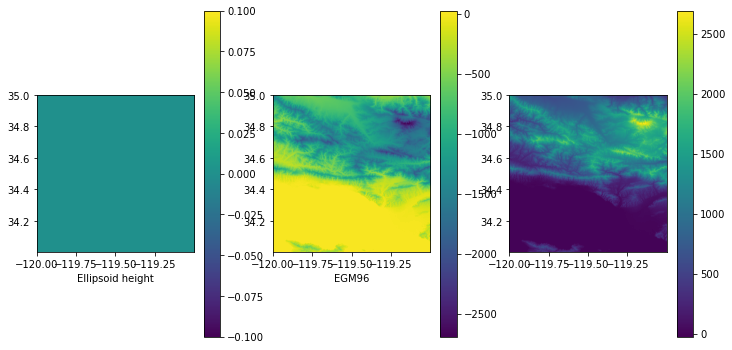

In [13]:
gDEM, ext = loadData('N34W120.tif')
eDEM, ext = loadData('N34W120_wgs84.tif')
fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot(1,3,1)
im1 = ax1.imshow(eDEM, extent=ext)
fig.colorbar(im1)
ax1.set_xlabel('Ellipsoid height')
ax2 = plt.subplot(1,3,2)
im2 = ax2.imshow(eDEM-gDEM, extent=ext)
fig.colorbar(im2)
ax2.set_xlabel('EGM96')
ax3 = plt.subplot(1,3,3)
im3 = ax3.imshow(gDEM, extent=ext)
fig.colorbar(im3)
plt.show()

## Reproyección de rásteres geocodificados

Existen numerosos casos de uso en los que es necesario reproyectar los datos geocodificados. A continuación se enumeran algunos ejemplos:

1. Una región de interés es demasiado grande para el análisis con una única zona UTM (p. ej., datos de Landsat). Para crear un gran mosaico, la reproyección es inevitable.

2. Reunir DEMs de diferentes fuentes. SRTM solo abarca las latitudes de 60N a 60S. Para las regiones árticas, los DEM se distribuyen normalmente en coordenadas estereográficas polares. Para el procesamiento, se necesitaría construir un solo DEM proyectando los DEM a un sistema común.

3. Ciertas proyecciones son más propicias para la comparación con conjuntos de datos de campo, por ejemplo, zonas UTM donde las dimensiones de los píxeles se pueden relacionar directamente con el área en el suelo.

4. Combinar datos de diferentes fuentes. Por ejemplo, el conjunto de datos SRTM se distribuye en coordenadas lat/lon, mientras que Landsat y Sentinel-2 se distribuyen en coordenadas estereográficas polares/UTM.

En esta sección, usaremos **gdalwarp** para reproyectar datos de un sistema de coordenadas a otro.

### Reproyección simple

Las banderas clave para **gdalwarp** para la reproyección son

1. Opción "-t_srs" para indicar el sistema de proyección de salida
2. Opción "-r" para el algoritmo de remuestreo
3. Opción "-te" para la extensión espacial de la cuadrícula de salida
4. Opción "-tr" para controlar el espaciado de la cuadrícula de salida (o) opción "-ts" para el tamaño de salida

Para comenzar, vamos a reproyectar el DEM de Groenlandia a la extensión de salida predeterminada y al espaciado que se determina automáticamente para las coordenadas de latitud/longitud WGS84.

In [14]:
!gdalwarp -t_srs EPSG:4326 NETCDF:"Greenland1km.nc":topg -srcnodata None -dstnodata None -overwrite Greenland_ll_default.tif

Creating output file that is 4764P x 1201L.
Processing NETCDF:Greenland1km.nc:topg [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


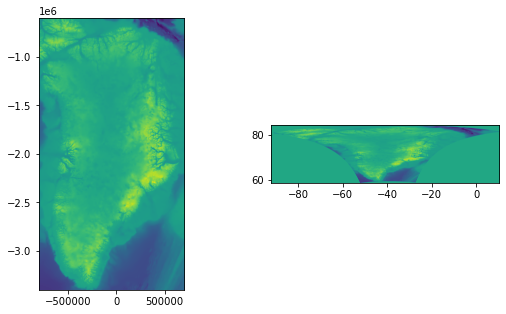

Original DEM size:  (2801, 1501)
Resampled DEM size:  (1201, 4764)


In [15]:
pdem, pext = loadData('NETCDF:"Greenland1km.nc":topg')
ldem, lext = loadData('Greenland_ll_default.tif')

plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.imshow(pdem, extent=pext)
plt.subplot(1,2,2)
plt.imshow(ldem, extent=lext)
plt.show()
print('Original DEM size: ', pdem.shape)
print('Resampled DEM size: ', ldem.shape)
pdem = None
ldem = None

### Remuestreo con espaciado de salida específico

Recuerde del ejercicio anterior que el DEM de Groenlandia fue muestreado con un espacio de aproximadamente 1 km. Podemos usar un número similar para el remuestreo.

In [16]:
!gdalwarp -t_srs EPSG:4326 -tr 0.06 0.01 -overwrite NETCDF:"Greenland1km.nc":topg -srcnodata None -dstnodata None Greenland_ll_similar.tif

Creating output file that is 1710P x 2587L.
Processing NETCDF:Greenland1km.nc:topg [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


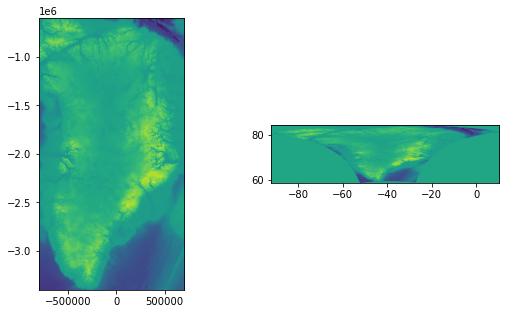

Original DEM size:  (2801, 1501)
Resampled DEM size:  (2587, 1710)


In [17]:
pdem, pext = loadData('NETCDF:"Greenland1km.nc":topg')
ldem, lext = loadData('Greenland_ll_similar.tif')

plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.imshow(pdem, extent=pext)
plt.subplot(1,2,2)
plt.imshow(ldem, extent=lext)
plt.show()
print('Original DEM size: ', pdem.shape)
print('Resampled DEM size: ', ldem.shape)
pdem = None
ldem = None

### Remuestreo a una cuadrícula predefinida

Esta es una función muy útil para enviar datos automáticamente a una cuadrícula que es autoconsistente. Estas cuadrículas normalmente se disponen de una manera en la que las coordenadas iniciales son un múltiplo del espaciado de píxeles. Esto se logra a través de la opción "-tap" y es más útil para operaciones eficientes.

Vamos a reproyectar subconjuntos de un DEM al mismo sistema de coordenadas con y sin la opción "-tocar" y comparar las cuadrículas de salida.

In [18]:
##Permite subconjunto sin la opción -tap
!gdalwarp -of VRT -t_srs EPSG:32611 -te -119.8 34.3 -119.6 34.5 -te_srs EPSG:4326 -tr 100 100 N34W120.tif subset1.vrt
!gdalwarp -of VRT -t_srs EPSG:32611 -te -119.9 34.2 -119.7 34.4 -te_srs EPSG:4326 -tr 100 100 N34W120.tif subset2.vrt

Creating output file that is 190P x 217L.
Processing N34W120.tif [1/1] : 0Using internal nodata values (e.g. -32768) for image N34W120.tif.
Copying nodata values from source N34W120.tif to destination subset1.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 190P x 217L.
Processing N34W120.tif [1/1] : 0Using internal nodata values (e.g. -32768) for image N34W120.tif.
Copying nodata values from source N34W120.tif to destination subset2.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.


In [19]:
!gdalinfo subset1.vrt

Driver: VRT/Virtual Raster
Files: subset1.vrt
       N34W120.tif
Size is 190, 217
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 11N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 11N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-117,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
            ID["EPSG",

In [20]:
!gdalinfo subset2.vrt

Driver: VRT/Virtual Raster
Files: subset2.vrt
       N34W120.tif
Size is 190, 217
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 11N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 11N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-117,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
            ID["EPSG",

Tenga en cuenta que las salidas no están alineadas, es decir, las esquinas superiores izquierdas no varían en un múltiplo de espacio entre píxeles. Ahora, intentemos con la opción "-tap".

In [21]:
##Permite subconjunto con la opción -tap
!gdalwarp -of VRT -t_srs EPSG:32611 -te -119.8 34.3 -119.6 34.5 -te_srs EPSG:4326 -tr 100 100 -tap N34W120.tif aligned_subset1.vrt
!gdalwarp -of VRT -t_srs EPSG:32611 -te -119.9 34.2 -119.7 34.4 -te_srs EPSG:4326 -tr 100 100 -tap N34W120.tif aligned_subset2.vrt

Creating output file that is 190P x 218L.
Processing N34W120.tif [1/1] : 0Using internal nodata values (e.g. -32768) for image N34W120.tif.
Copying nodata values from source N34W120.tif to destination aligned_subset1.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 192P x 218L.
Processing N34W120.tif [1/1] : 0Using internal nodata values (e.g. -32768) for image N34W120.tif.
Copying nodata values from source N34W120.tif to destination aligned_subset2.vrt.
...10...20...30...40...50...60...70...80...90...100 - done.


In [22]:
!gdalinfo aligned_subset1.vrt

Driver: VRT/Virtual Raster
Files: aligned_subset1.vrt
       N34W120.tif
Size is 190, 218
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 11N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 11N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-117,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
            ID

In [23]:
!gdalinfo aligned_subset2.vrt

Driver: VRT/Virtual Raster
Files: aligned_subset2.vrt
       N34W120.tif
Size is 192, 218
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 11N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 11N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-117,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
            ID

Tenga en cuenta que los píxeles de la parte superior izquierda ahora difieren exactamente en un múltiplo del espaciado de píxeles. Estos subconjuntos se pueden superponer fácilmente uno encima del otro para su análisis/comparación sin procesamiento adicional.

## Reproyectar datos de franja

De los ejemplos de procesamiento ISCE, debe haber notado que las imágenes SAR no se distribuyen en cuadrículas alineadas de norte a sur, de oeste a este. La cuadrícula de imágenes está alineada con la trayectoria del satélite o la aeronave y es posible que no estén perfectamente de norte a sur. GDAL ofrece dos opciones para geocodificar este tipo de conjunto de datos

1. Puntos de control de tierra (GCP)
2. Matrices de geolocalización

### Geocodificación usando GCP

En la sección introductoria sobre datos ráster, ya vimos que algunos formatos de datos incluyen soporte para GCP. Estos representan un mapeo entre la línea/píxel y las coordenadas del mapa. Sobre terreno muy llano o sobre océano/hielo marino: esta información es más que suficiente para geocodificar datos con una precisión razonable (piensa por qué???). Solo describimos el procedimiento en este tutorial debido a limitaciones de tiempo. Se anima a los usuarios a probar esto por su cuenta.

```bash
> gdalinfo /vsizip/S1A_IW_GRDH_1SDV_20170127T001111_20170127T001136_015010_01884A_9043.zip/S1A_IW_GRDH_1SDV_20170127T001111_20170127T001136_015010_01884A_9043.SAFE/measurement/s1a-iw-grd-vv-20170127t001111-20170127t001136-015010-01884a-001.tiff

Driver: GTiff/GeoTIFF
Files: /vsizip/S1A_IW_GRDH_1SDV_20170127T001111_20170127T001136_015010_01884A_9043.zip/S1A_IW_GRDH_1SDV_20170127T001111_20170127T001136_015010_01884A_9043.SAFE/measurement/s1a-iw-grd-vv-20170127t001111-20170127t001136-015010-01884a-001.tiff
Size is 25505, 16729
Coordinate System is `'
GCP Projection =
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["unnamed",6378137,298.2572235604902,
            AUTHORITY["EPSG","4326"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
GCP[  0]: Id=1, Info=
          (0,0) -> (-94.005922908642,33.2767568872629,82.4891335545108)
GCP[  1]: Id=2, Info=
          (1276,0) -> (-93.8713725178248,33.298342788709,82.4890268715099)
GCP[  2]: Id=3, Info=
          (2552,0) -> (-93.736756133881,33.3197832475533,82.4889215333387)
GCP[  3]: Id=4, Info=
          (3828,0) -> (-93.6020741174325,33.3410780749001,82.4888174766675)
GCP[  4]: Id=5, Info=
          (5104,0) -> (-93.4673268317664,33.3622270828064,82.4887146400288)
GCP[  5]: Id=6, Info=
          (6380,0) -> (-93.3325146423635,33.3832300843644,82.4886129721999)
GCP[  6]: Id=7, Info=
          (7656,0) -> (-93.1976379167661,33.404086893728,82.4885124303401)
GCP[  7]: Id=8, Info=
          (8932,0) -> (-93.0626970245939,33.4247973261167,82.488412976265)
GCP[  8]: Id=9, Info=
          (10208,0) -> (-92.9276923375967,33.4453611978123,82.4883145680651)
GCP[  9]: Id=10, Info=
          (11484,0) -> (-92.7926242296921,33.4657783261598,82.4882171778008)
GCP[ 10]: Id=11, Info=
          (12760,0) -> (-92.6574930769715,33.4860485295715,82.4881207821891)
GCP[ 11]: Id=12, Info=
          (14036,0) -> (-92.5222992576794,33.5061716275367,82.4880253477022)
GCP[ 12]: Id=13, Info=
          (15312,0) -> (-92.387043152181,33.5261474406317,82.4879308547825)
GCP[ 13]: Id=14, Info=
          (16588,0) -> (-92.2517251429341,33.5459757905291,82.4878372829407)
GCP[ 14]: Id=15, Info=
          (17864,0) -> (-92.1163456144782,33.5656565000047,82.487744611688)
GCP[ 15]: Id=16, Info=
          (19140,0) -> (-91.9809049534456,33.5851893929409,82.4876528279856)
GCP[ 16]: Id=17, Info=
          (20416,0) -> (-91.845403548587,33.6045742943281,82.4875619197264)
GCP[ 17]: Id=18, Info=
          (21692,0) -> (-91.7098417907929,33.6238110302665,82.4874718654901)
GCP[ 18]: Id=19, Info=
          (22968,0) -> (-91.5742200730755,33.6428994279739,82.4873826541007)
GCP[ 19]: Id=20, Info=
          (24244,0) -> (-91.4385387904629,33.6618393158058,82.4872942790389)
GCP[ 20]: Id=21, Info=
          (25504,0) -> (-91.3045007790343,33.6803958180407,82.487207817845)
GCP[ 21]: Id=22, Info=
          (0,2008) -> (-94.047689959274,33.4574743168206,86.8307519014925)
GCP[ 22]: Id=23, Info=
          (1276,2008) -> (-93.9128610831397,33.4790567161726,86.8306398028508)
GCP[ 23]: Id=24, Info=
          (2552,2008) -> (-93.7779655913483,33.500492683175,86.8305291002616)
GCP[ 24]: Id=25, Info=
          (3828,2008) -> (-93.6430038546116,33.5217820267718,86.8304197173566)
GCP[ 25]: Id=26, Info=
          (5104,2008) -> (-93.507976245905,33.5429245569615,86.8303116057068)
GCP[ 26]: Id=27, Info=
          (6380,2008) -> (-93.3728831400487,33.563920084869,86.8302047140896)
GCP[ 27]: Id=28, Info=
          (7656,2008) -> (-93.2377249136249,33.5847684227625,86.8300989894196)
GCP[ 28]: Id=29, Info=
          (8932,2008) -> (-93.1025019450354,33.6054693840483,86.8299943935126)
GCP[ 29]: Id=30, Info=
          (10208,2008) -> (-92.9672146145922,33.6260227832614,86.8298908965662)
GCP[ 30]: Id=31, Info=
          (11484,2008) -> (-92.8318633045886,33.6464284360586,86.8297884585336)
GCP[ 31]: Id=32, Info=
          (12760,2008) -> (-92.696448399334,33.6666861592187,86.8296870533377)
GCP[ 32]: Id=33, Info=
          (14036,2008) -> (-92.5609702851583,33.686795770646,86.8295866586268)
GCP[ 33]: Id=34, Info=
          (15312,2008) -> (-92.4254293504009,33.7067570893768,86.8294872529805)
GCP[ 34]: Id=35, Info=
          (16588,2008) -> (-92.2898259854009,33.7265699355856,86.8293888093904)
GCP[ 35]: Id=36, Info=
          (17864,2008) -> (-92.1541605825019,33.7462341305888,86.8292913101614)
GCP[ 36]: Id=37, Info=
          (19140,2008) -> (-92.0184335360754,33.7657494968454,86.8291947441176)
GCP[ 37]: Id=38, Info=
          (20416,2008) -> (-91.8826452425569,33.7851158579568,86.8290990917012)
GCP[ 38]: Id=39, Info=
          (21692,2008) -> (-91.7467961004747,33.8043330386673,86.8290043342859)
GCP[ 39]: Id=40, Info=
          (22968,2008) -> (-91.6108865104378,33.8234008648703,86.8289104709402)
GCP[ 40]: Id=41, Info=
          (24244,2008) -> (-91.474916875033,33.8423191636278,86.8288174821064)
GCP[ 41]: Id=42, Info=
          (25504,2008) -> (-91.3405936623981,33.8608533477523,86.8287265086547)
GCP[ 42]: Id=43, Info=
          (0,4016) -> (-94.0896851063414,33.6381587216162,83.1414270717651)
GCP[ 43]: Id=44, Info=
          (1276,4016) -> (-93.9545737968323,33.6597382189906,83.1413188902661)
GCP[ 44]: Id=45, Info=
          (2552,4016) -> (-93.8193953343885,33.6811702724005,83.1412120880559)
GCP[ 45]: Id=46, Info=
          (3828,4016) -> (-93.6841500913544,33.7024546902725,83.1411065980792)
GCP[ 46]: Id=47, Info=
          (5104,4016) -> (-93.5488384429507,33.7235912819923,83.1410023635253)
GCP[ 47]: Id=48, Info=
          (6380,4016) -> (-93.4134607667759,33.7445798579914,83.1408993322402)
GCP[ 48]: Id=49, Info=
          (7656,4016) -> (-93.2780174426532,33.7654202297782,83.1407974530011)
GCP[ 49]: Id=50, Info=
          (8932,4016) -> (-93.1425088526288,33.7861122099448,83.1406966922805)
GCP[ 50]: Id=51, Info=
          (10208,4016) -> (-93.0069353810106,33.8066556121666,83.1405970100313)
GCP[ 51]: Id=52, Info=
          (11484,4016) -> (-92.8712974143956,33.827050251205,83.1404983736575)
GCP[ 52]: Id=53, Info=
          (12760,4016) -> (-92.7355953416676,33.847295942914,83.1404007524252)
GCP[ 53]: Id=54, Info=
          (14036,4016) -> (-92.5998295539722,33.86739250425,83.1403041221201)
GCP[ 54]: Id=55, Info=
          (15312,4016) -> (-92.4640004446803,33.8873397532833,83.1402084585279)
GCP[ 55]: Id=56, Info=
          (16588,4016) -> (-92.3281084093585,33.9071375092078,83.1401137458161)
GCP[ 56]: Id=57, Info=
          (17864,4016) -> (-92.1921538457568,33.9267855923485,83.1400199588388)
GCP[ 57]: Id=58, Info=
          (19140,4016) -> (-92.0561371538186,33.9462838241655,83.139927085489)
GCP[ 58]: Id=59, Info=
          (20416,4016) -> (-91.9200587357033,33.9656320272558,83.139835103415)
GCP[ 59]: Id=60, Info=
          (21692,4016) -> (-91.7839189958028,33.9848300253565,83.1397440042347)
GCP[ 60]: Id=61, Info=
          (22968,4016) -> (-91.6477183407148,34.0038776433544,83.1396537711844)
GCP[ 61]: Id=62, Info=
          (24244,4016) -> (-91.5114571791219,34.0227747073074,83.1395643977448)
GCP[ 62]: Id=63, Info=
          (25504,4016) -> (-91.3768456493388,34.0412869145492,83.1394769735634)
GCP[ 63]: Id=64, Info=
          (0,6024) -> (-94.1314913043126,33.8188767279123,94.8706692503765)
GCP[ 64]: Id=65, Info=
          (1276,6024) -> (-93.9960966137392,33.8404529544535,94.8705469993874)
GCP[ 65]: Id=66, Info=
          (2552,6024) -> (-93.8606341419723,33.8618807384932,94.8704262357205)
GCP[ 66]: Id=67, Info=
          (3828,6024) -> (-93.7251042712821,33.8831598863366,94.8703068885952)
GCP[ 67]: Id=68, Info=
          (5104,6024) -> (-93.5895073864032,33.9042902053498,94.8701889030635)
GCP[ 68]: Id=69, Info=
          (6380,6024) -> (-93.4538438741112,33.9252715040336,94.8700722213835)
GCP[ 69]: Id=70, Info=
          (7656,6024) -> (-93.3181141231331,33.9461035920414,94.8699568007141)
GCP[ 70]: Id=71, Info=
          (8932,6024) -> (-93.1823185241957,33.9667862801773,94.8698425991461)
GCP[ 71]: Id=72, Info=
          (10208,6024) -> (-93.0464574701047,33.9873193803885,94.8697295757011)
GCP[ 72]: Id=73, Info=
          (11484,6024) -> (-92.9105313558033,34.0077027057613,94.8696177061647)
GCP[ 73]: Id=74, Info=
          (12760,6024) -> (-92.7745405783956,34.0279360705236,94.8695069514215)
GCP[ 74]: Id=75, Info=
          (14036,6024) -> (-92.638485537139,34.0480192900511,94.8693972947076)
GCP[ 75]: Id=76, Info=
          (15312,6024) -> (-92.5023666334231,34.0679521808751,94.869288709946)
GCP[ 76]: Id=77, Info=
          (16588,6024) -> (-92.3661842707519,34.0877345606912,94.8691811719909)
GCP[ 77]: Id=78, Info=
          (17864,6024) -> (-92.2299388547413,34.1073662483635,94.8690746631473)
GCP[ 78]: Id=79, Info=
          (19140,6024) -> (-92.093630793139,34.1268470639269,94.8689691703767)
GCP[ 79]: Id=80, Info=
          (20416,6024) -> (-91.9572604958582,34.1461768285875,94.8688646741211)
GCP[ 80]: Id=81, Info=
          (21692,6024) -> (-91.8208283750074,34.1653553647229,94.8687611622736)
GCP[ 81]: Id=82, Info=
          (22968,6024) -> (-91.6843348448802,34.1843824958893,94.8686586217955)
GCP[ 82]: Id=83, Info=
          (24244,6024) -> (-91.5477803218575,34.2032580468394,94.8685570405796)
GCP[ 83]: Id=84, Info=
          (25504,6024) -> (-91.4128786394285,34.2217480026286,94.868457662873)
GCP[ 84]: Id=85, Info=
          (0,8032) -> (-94.1726812320393,33.9996951265157,145.826850661077)
GCP[ 85]: Id=86, Info=
          (1276,8032) -> (-94.037000633364,34.0212674230856,145.826668350957)
GCP[ 86]: Id=87, Info=
          (2552,8032) -> (-93.9012516560656,34.0426902688802,145.826487941667)
GCP[ 87]: Id=88, Info=
          (3828,8032) -> (-93.7654346892336,34.0639634686949,145.826309361495)
GCP[ 88]: Id=89, Info=
          (5104,8032) -> (-93.6295501244325,34.0850868284084,145.826132549904)
GCP[ 89]: Id=90, Info=
          (6380,8032) -> (-93.4935983552818,34.1060601550547,145.825957460329)
GCP[ 90]: Id=91, Info=
          (7656,8032) -> (-93.3575797773681,34.126883256842,145.825784043409)
GCP[ 91]: Id=92, Info=
          (8932,8032) -> (-93.2214947882966,34.1475559431492,145.825612259097)
GCP[ 92]: Id=93, Info=
          (10208,8032) -> (-93.0853437877728,34.1680780245185,145.825442066416)
GCP[ 93]: Id=94, Info=
          (11484,8032) -> (-92.9491271776626,34.188449312651,145.825273439288)
GCP[ 94]: Id=95, Info=
          (12760,8032) -> (-92.8128453620176,34.2086696204089,145.825106347911)
GCP[ 95]: Id=96, Info=
          (14036,8032) -> (-92.67649874707,34.2287387618212,145.824940763414)
GCP[ 96]: Id=97, Info=
          (15312,8032) -> (-92.5400877412122,34.2486565520923,145.824776669964)
GCP[ 97]: Id=98, Info=
          (16588,8032) -> (-92.4036127549806,34.2684228076089,145.824614039622)
GCP[ 98]: Id=99, Info=
          (17864,8032) -> (-92.2670742010541,34.2880373459456,145.824452857487)
GCP[ 99]: Id=100, Info=
          (19140,8032) -> (-92.1304724942741,34.3074999858663,145.824293107726)
GCP[100]: Id=101, Info=
          (20416,8032) -> (-91.9938080516782,34.3268105473252,145.824134772643)
GCP[101]: Id=102, Info=
          (21692,8032) -> (-91.8570812925285,34.3459688514672,145.823977841064)
GCP[102]: Id=103, Info=
          (22968,8032) -> (-91.7202926382989,34.3649747206351,145.823822300881)
GCP[103]: Id=104, Info=
          (24244,8032) -> (-91.5834425125734,34.3838279783886,145.823668140918)
GCP[104]: Id=105, Info=
          (25504,8032) -> (-91.4482484714778,34.4022949074902,145.823517258279)
GCP[105]: Id=106, Info=
          (0,10040) -> (-94.2139238725098,34.1805072851632,198.548701436259)
GCP[106]: Id=107, Info=
          (1276,10040) -> (-94.0779547882432,34.2020757807732,198.548456720077)
GCP[107]: Id=108, Info=
          (2552,10040) -> (-93.9419167279478,34.2234938122191,198.548214334995)
GCP[108]: Id=109, Info=
          (3828,10040) -> (-93.805810087086,34.2447611828731,198.547974212095)
GCP[109]: Id=110, Info=
          (5104,10040) -> (-93.6696352636983,34.2658776971961,198.54773629643)
GCP[110]: Id=111, Info=
          (6380,10040) -> (-93.5333926579617,34.2868431608136,198.547500534914)
GCP[111]: Id=112, Info=
          (7656,10040) -> (-93.3970826720872,34.307657380537,198.54726688005)
GCP[112]: Id=113, Info=
          (8932,10040) -> (-93.2607057103604,34.3283201643619,198.547035292722)
GCP[113]: Id=114, Info=
          (10208,10040) -> (-93.124262179218,34.3488313214617,198.546805738471)
GCP[114]: Id=115, Info=
          (11484,10040) -> (-92.9877524873046,34.3691906621842,198.546578184702)
GCP[115]: Id=116, Info=
          (12760,10040) -> (-92.851177045497,34.3893979980535,198.546352600679)
GCP[116]: Id=117, Info=
          (14036,10040) -> (-92.7145362668988,34.4094531417768,198.546128966846)
GCP[117]: Id=118, Info=
          (15312,10040) -> (-92.5778305668214,34.4293559072516,198.545907253399)
GCP[118]: Id=119, Info=
          (16588,10040) -> (-92.4410603627686,34.4491061095739,198.545687450096)
GCP[119]: Id=120, Info=
          (17864,10040) -> (-92.3042260744354,34.4687035650432,198.545469530858)
GCP[120]: Id=121, Info=
          (19140,10040) -> (-92.1673281237276,34.4881480911647,198.545253487304)
GCP[121]: Id=122, Info=
          (20416,10040) -> (-92.0303669347938,34.5074395066495,198.545039299875)
GCP[122]: Id=123, Info=
          (21692,10040) -> (-91.8933429340491,34.5265776314174,198.544826953672)
GCP[123]: Id=124, Info=
          (22968,10040) -> (-91.7562565501562,34.5455622866038,198.54461644683)
GCP[124]: Id=125, Info=
          (24244,10040) -> (-91.6191082139124,34.5643932945809,198.544407761656)
GCP[125]: Id=126, Info=
          (25504,10040) -> (-91.4836192368266,34.5828372353663,198.544203476049)
GCP[126]: Id=127, Info=
          (0,12048) -> (-94.25432309759,34.3614557730504,302.946729348972)
GCP[127]: Id=128, Info=
          (1276,12048) -> (-94.1180621814358,34.383019675634,302.946361161768)
GCP[128]: Id=129, Info=
          (2552,12048) -> (-93.9817317837367,34.4044320795243,302.945996158756)
GCP[129]: Id=130, Info=
          (3828,12048) -> (-93.8453322976822,34.4256927883587,302.945634277537)
GCP[130]: Id=131, Info=
          (5104,12048) -> (-93.7088641201605,34.4468016066707,302.945275451057)
GCP[131]: Id=132, Info=
          (6380,12048) -> (-93.5723276511671,34.4677583399954,302.944919633679)
GCP[132]: Id=133, Info=
          (7656,12048) -> (-93.4357232935763,34.4885627949145,302.944566783495)
GCP[133]: Id=134, Info=
          (8932,12048) -> (-93.2990514530748,34.5092147790767,302.94421685487)
GCP[134]: Id=135, Info=
          (10208,12048) -> (-93.1623125381443,34.5297141012091,302.943869820796)
GCP[135]: Id=136, Info=
          (11484,12048) -> (-93.0255069600393,34.5500605711292,302.943525647745)
GCP[136]: Id=137, Info=
          (12760,12048) -> (-92.8886351327418,34.5702539997606,302.943184312433)
GCP[137]: Id=138, Info=
          (14036,12048) -> (-92.7516974728963,34.5902941991506,302.942845787853)
GCP[138]: Id=139, Info=
          (15312,12048) -> (-92.6146943997393,34.6101809824883,302.94251004979)
GCP[139]: Id=140, Info=
          (16588,12048) -> (-92.4776263350394,34.6299141641203,302.942177088931)
GCP[140]: Id=141, Info=
          (17864,12048) -> (-92.3404937030593,34.6494935595636,302.941846882924)
GCP[141]: Id=142, Info=
          (19140,12048) -> (-92.203296930544,34.6689189855134,302.941519422457)
GCP[142]: Id=143, Info=
          (20416,12048) -> (-92.0660364467276,34.6881902598488,302.941194689833)
GCP[143]: Id=144, Info=
          (21692,12048) -> (-91.9287126833378,34.7073072016389,302.940872677602)
GCP[144]: Id=145, Info=
          (22968,12048) -> (-91.7913260745629,34.7262696311536,302.940553373657)
GCP[145]: Id=146, Info=
          (24244,12048) -> (-91.6538770569317,34.7450773698865,302.940236770548)
GCP[146]: Id=147, Info=
          (25504,12048) -> (-91.5180907266005,34.7634973083089,302.93992678076)
GCP[147]: Id=148, Info=
          (0,14056) -> (-94.2969246946118,34.5420594060516,289.679583688267)
GCP[148]: Id=149, Info=
          (1276,14056) -> (-94.1603681371615,34.5636216263085,289.679230171256)
GCP[149]: Id=150, Info=
          (2552,14056) -> (-94.0237415667509,34.5850313088514,289.678879768588)
GCP[150]: Id=151, Info=
          (3828,14056) -> (-93.8870453754225,34.6062882573308,289.678532412276)
GCP[151]: Id=152, Info=
          (5104,14056) -> (-93.7502799599306,34.6273922761226,289.678188038059)
GCP[152]: Id=153, Info=
          (6380,14056) -> (-93.6134457210128,34.6483431704603,289.677846601233)
GCP[153]: Id=154, Info=
          (7656,14056) -> (-93.4765430630425,34.6691407465041,289.677508051507)
GCP[154]: Id=155, Info=
          (8932,14056) -> (-93.3395723938599,34.6897848113797,289.677172348835)
GCP[155]: Id=156, Info=
          (10208,14056) -> (-93.2025341246687,34.710275173207,289.676839462481)
GCP[156]: Id=157, Info=
          (11484,14056) -> (-93.0654286699406,34.7306116411265,289.676509361714)
GCP[157]: Id=158, Info=
          (12760,14056) -> (-92.9282564473089,34.7507940253259,289.67618201673)
GCP[158]: Id=159, Info=
          (14036,14056) -> (-92.7910178774539,34.7708221370681,289.675857400522)
GCP[159]: Id=160, Info=
          (15312,14056) -> (-92.6537133839908,34.7906957887171,289.675535497256)
GCP[160]: Id=161, Info=
          (16588,14056) -> (-92.5163433933767,34.8104147937606,289.675216287374)
GCP[161]: Id=162, Info=
          (17864,14056) -> (-92.378908334844,34.829978966828,289.674899755977)
GCP[162]: Id=163, Info=
          (19140,14056) -> (-92.2414086403649,34.8493881237039,289.674585882574)
GCP[163]: Id=164, Info=
          (20416,14056) -> (-92.1038447446349,34.8686420813381,289.674274659716)
GCP[164]: Id=165, Info=
          (21692,14056) -> (-91.9662170850546,34.8877406578559,289.673966070637)
GCP[165]: Id=166, Info=
          (22968,14056) -> (-91.8285261016697,34.9066836725741,289.673660114408)
GCP[166]: Id=167, Info=
          (24244,14056) -> (-91.6907722370178,34.9254709460289,289.6733567724)
GCP[167]: Id=168, Info=
          (25504,14056) -> (-91.5546844246163,34.943869644052,289.673059795983)
GCP[168]: Id=169, Info=
          (0,16064) -> (-94.3390836183297,34.7227358640494,306.064091209322)
GCP[169]: Id=170, Info=
          (1276,16064) -> (-94.2022389900078,34.7442943444211,306.063717443496)
GCP[170]: Id=171, Info=
          (2552,16064) -> (-94.0653231775186,34.7656993670926,306.063346951269)
GCP[171]: Id=172, Info=
          (3828,16064) -> (-93.9283366316392,34.7869507241728,306.062979667448)
GCP[172]: Id=173, Info=
          (5104,16064) -> (-93.7912798016242,34.8080482097263,306.062615531497)
GCP[173]: Id=174, Info=
          (6380,16064) -> (-93.654153135386,34.828991619729,306.062254494056)
GCP[174]: Id=175, Info=
          (7656,16064) -> (-93.5169570799065,34.8497807519904,306.061896506697)
GCP[175]: Id=176, Info=
          (8932,16064) -> (-93.3796920817076,34.870415406069,306.061541529372)
GCP[176]: Id=177, Info=
          (10208,16064) -> (-93.2423585872865,34.8908953831972,306.061189531349)
GCP[177]: Id=178, Info=
          (11484,16064) -> (-93.1049570434748,34.9112204862197,306.06084048003)
GCP[178]: Id=179, Info=
          (12760,16064) -> (-92.9674878977178,34.9313905195468,306.060494344682)
GCP[179]: Id=180, Info=
          (14036,16064) -> (-92.8299515982852,34.9514052891187,306.060151105747)
GCP[180]: Id=181, Info=
          (15312,16064) -> (-92.6923485944371,34.9712646023787,306.059810741805)
GCP[181]: Id=182, Info=
          (16588,16064) -> (-92.5546793365657,34.9909682682498,306.059473229572)
GCP[182]: Id=183, Info=
          (17864,16064) -> (-92.416944276331,35.0105160971143,306.059138556942)
GCP[183]: Id=184, Info=
          (19140,16064) -> (-92.2791438667984,35.0299079007933,306.058806712739)
GCP[184]: Id=185, Info=
          (20416,16064) -> (-92.141278562573,35.0491434925276,306.058477675542)
GCP[185]: Id=186, Info=
          (21692,16064) -> (-92.0033488199136,35.068222686963,306.058151436038)
GCP[186]: Id=187, Info=
          (22968,16064) -> (-91.8653550967926,35.0871453001428,306.057827989571)
GCP[187]: Id=188, Info=
          (24244,16064) -> (-91.7272978528524,35.1059111495157,306.057507327758)
GCP[188]: Id=189, Info=
          (25504,16064) -> (-91.5909098537345,35.1242876858511,306.057193404995)
GCP[189]: Id=190, Info=
          (0,16728) -> (-94.3542122503434,34.782295044955,246.882710632868)
GCP[190]: Id=191, Info=
          (1276,16728) -> (-94.2172619912602,34.8038552608933,246.882406512275)
GCP[191]: Id=192, Info=
          (2552,16728) -> (-94.080240740657,34.8252615995711,246.882105198689)
GCP[192]: Id=193, Info=
          (3828,16728) -> (-93.9431489136834,34.8465138598918,246.881806625053)
GCP[193]: Id=194, Info=
          (5104,16728) -> (-93.8059869285803,34.8676118418325,246.881510730833)
GCP[194]: Id=195, Info=
          (6380,16728) -> (-93.6687552061895,34.8885553465287,246.881217458285)
GCP[195]: Id=196, Info=
          (7656,16728) -> (-93.5314541698086,34.9093441763043,246.88092676457)
GCP[196]: Id=197, Info=
          (8932,16728) -> (-93.3940842451943,34.929978134678,246.880638615228)
GCP[197]: Id=198, Info=
          (10208,16728) -> (-93.2566458606044,34.9504570263632,246.880352959037)
GCP[198]: Id=199, Info=
          (11484,16728) -> (-93.1191394468253,34.9707806572715,246.880069776438)
GCP[199]: Id=200, Info=
          (12760,16728) -> (-92.9815654371698,34.9909488345194,246.879789030179)
GCP[200]: Id=201, Info=
          (14036,16728) -> (-92.8439242674496,35.0109613664389,246.879510701634)
GCP[201]: Id=202, Info=
          (15312,16728) -> (-92.7062163759374,35.0308180625903,246.879234765656)
GCP[202]: Id=203, Info=
          (16588,16728) -> (-92.5684422033351,35.050518733772,246.878961206414)
GCP[203]: Id=204, Info=
          (17864,16728) -> (-92.4306021927598,35.0700631920292,246.878689996898)
GCP[204]: Id=205, Info=
          (19140,16728) -> (-92.2926967897523,35.0894512506582,246.878421133384)
GCP[205]: Id=206, Info=
          (20416,16728) -> (-92.1547264422987,35.1086827242094,246.878154591657)
GCP[206]: Id=207, Info=
          (21692,16728) -> (-92.0166916008444,35.1277574284911,246.87789036613)
GCP[207]: Id=208, Info=
          (22968,16728) -> (-91.8785927182643,35.1466751805799,246.8776284419)
GCP[208]: Id=209, Info=
          (24244,16728) -> (-91.7404302497364,35.1654357988433,246.877368811518)
GCP[209]: Id=210, Info=
          (25504,16728) -> (-91.6039382777295,35.1838068073759,246.877114677802)
Metadata:
  AREA_OR_POINT=Area
  TIFFTAG_DATETIME=2017:01:27 08:07:14
  TIFFTAG_IMAGEDESCRIPTION=Sentinel-1A IW GRD HR L1
  TIFFTAG_SOFTWARE=Sentinel-1 IPF 002.72
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (    0.0,    0.0)
Lower Left  (    0.0,16729.0)
Upper Right (25505.0,    0.0)
Lower Right (25505.0,16729.0)
Center      (12752.5, 8364.5)
Band 1 Block=25505x1 Type=UInt16, ColorInterp=Gray
```

Para geocodificar este conjunto de datos en una cuadrícula uniforme de latitud y longitud, podemos usar

```bash
> gdalwarp -t_srs EPSG:4326 -tr 0.003 0.003 -r average /vsizip/S1A_IW_GRDH_1SDV_20170127T001111_20170127T001136_015010_01884A_9043.zip/S1A_IW_GRDH_1SDV_20170127T001111_20170127T001136_015010_01884A_9043.SAFE/measurement/s1a-iw-grd-vv-20170127t001111-20170127t001136-015010-01884a-001.tiff  geocoded_with_gcp.tif
```

Hay otras opciones de entrada como el orden del polinomio ("-order") y el transformador de placa delgada ("-tps") que permiten un mayor control sobre la geocodificación mediante GCP.

### Geocodificación usando matrices de geolocalización

*¡Tenga en cuenta que esta sección requiere que haya procesado un interferograma!*

En esta sección, proporcionaremos ejemplos programáticos de cómo se pueden usar las matrices lon/lat o x/y píxel por píxel para imágenes de barrido para geocodificar directamente los datos sin ninguna herramienta de procesamiento de radar especializada. Tenga en cuenta que ISCE ya genera estos archivos como parte del paso de procesamiento "topo" en stripmapApp.py o topsApp.py. El requisito principal es que estas matrices lon/lat o x/y tengan las mismas dimensiones que la imagen ráster que intenta geocodificar.

#### Localización de un píxel con ubicación conocida en una imagen SAR/InSAR

Antes de pasar a la geocodificación de imágenes completas, a menudo nos encontramos con el caso de uso en el que las personas desean identificar rápidamente una característica conocida (por ejemplo, una estación de GPS o un edificio) en una imagen de radar. Esto suele ser un desafío sin herramientas especializadas para el procesamiento de radar. Sin embargo, si las matrices de geolocalización están disponibles con la imagen de radar, esto se puede lograr fácilmente utilizando las funciones de transformación de coordenadas de GDAL. Lo demostraremos con un ejemplo.

Hemos incluido los resultados de una ejecución de procesamiento de stripmapApp.py en la subcarpeta llamada **stripmap**. Este es un par procesado en Hawai. La ubicación 119.7429N, -155.0750E representa la punta de una pared oceánica cerca del aeropuerto de Hilo (usando Google Earth). Intentaremos ubicar este píxel en la imagen de correlación de resolución completa en coordenadas de radar (topophase.cor.full). Usaremos los archivos lat (lat.rdr.full) y lon (lon.rdr.full) de resolución completa para esto.

In [24]:
def radarGeometryTransformer(infile, latfile, lonfile, epsg=4326):
    '''
    Cree un transformador de coordenadas para convertir las coordenadas del mapa en líneas/píxeles de imagen de radar.
    '''
    
    driver = gdal.GetDriverByName('VRT')
    inds = gdal.OpenShared(infile, gdal.GA_ReadOnly)
    tempds = driver.Create('', inds.RasterXSize, inds.RasterYSize, 0)
    inds = None
    
    tempds.SetMetadata({'SRS' : 'EPSG:{0}'.format(epsg),
                        'X_DATASET': lonfile,
                        'X_BAND' : '1',
                        'Y_DATASET': latfile,
                        'Y_BAND' : '1',
                        'PIXEL_OFFSET' : '0',
                        'LINE_OFFSET' : '0',
                        'PIXEL_STEP' : '1',
                        'LINE_STEP' : '1'}, 'GEOLOCATION')
    
    trans = gdal.Transformer( tempds, None, ['METHOD=GEOLOC_ARRAY'])
    
    return trans    

In [25]:
###Vamos a crear un transformador para nuestro conjunto de datos y probar
trans = radarGeometryTransformer('stripmap/geometry/z.rdr.full.vrt', 
                                 'stripmap/geometry/lat.rdr.full.vrt',
                                 'stripmap/geometry/lon.rdr.full.vrt')

###Consulte nuestra ubicación de interés
success, location = trans.TransformPoint(1, -155.0750, 19.7429, 0.)
if not success:
    print('Location outside the geolocation array range')

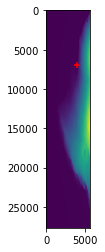

In [26]:
###Grafiquemos esto en un ráster para confirmar la ubicación máxima
data, ext = loadData('stripmap/geometry/z.rdr.full.vrt')
plt.figure()
plt.imshow(data)
plt.scatter(location[0], location[1], marker='+', c='r')
plt.show()
data = None

#### Geocodificación de una imagen completa

Podemos usar el mecanismo de arreglos de geolocalización para geocodificar la imagen completa usando la interfaz estándar **gdalwarp**. Lo lograremos creando un archivo VRT con la misma información que la función de python que se muestra arriba.

In [27]:
def geocodeUsingGdalWarp(infile, latfile, lonfile, outfile,
                         insrs=4326, outsrs=None,
                         spacing=None, fmt='GTiff', bounds=None,
                         method='near'):
    '''
    Geocodifique un archivo de franja usando los archivos de latitud y longitud correspondientes
    '''
    sourcexmltmpl = '''    <SimpleSource>
      <SourceFilename>{0}</SourceFilename>
      <SourceBand>{1}</SourceBand>
    </SimpleSource>'''
    
    driver = gdal.GetDriverByName('VRT')
    tempvrtname = 'stripmap/geocode.vrt'
    inds = gdal.OpenShared(infile, gdal.GA_ReadOnly)
    
    tempds = driver.Create(tempvrtname, inds.RasterXSize, inds.RasterYSize, 0)
    
    for ii in range(inds.RasterCount):
        band = inds.GetRasterBand(1)
        tempds.AddBand(band.DataType)
        tempds.GetRasterBand(ii+1).SetMetadata({'source_0': sourcexmltmpl.format(infile, ii+1)}, 'vrt_sources')
  
    sref = osr.SpatialReference()
    sref.ImportFromEPSG(insrs)
    srswkt = sref.ExportToWkt()

    tempds.SetMetadata({'SRS' : srswkt,
                        'X_DATASET': lonfile,
                        'X_BAND' : '1',
                        'Y_DATASET': latfile,
                        'Y_BAND' : '1',
                        'PIXEL_OFFSET' : '0',
                        'LINE_OFFSET' : '0',
                        'PIXEL_STEP' : '1',
                        'LINE_STEP' : '1'}, 'GEOLOCATION')
    
    band = None
    tempds = None 
    inds = None
    
    if spacing is None:
        spacing = [None, None]
    
    warpOptions = gdal.WarpOptions(format=fmt,
                                   xRes=spacing[0], yRes=spacing[0],
                                   dstSRS=outsrs, outputBounds = bounds, 
                                   resampleAlg=method, geoloc=True)
    gdal.Warp(outfile, tempvrtname, options=warpOptions)



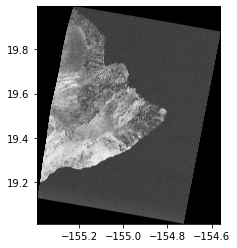

In [28]:
###Crear y visualizar resultados geocodificados
geocodeUsingGdalWarp('stripmap/interferogram/topophase.cor.full.vrt',
                     'stripmap/geometry/lat.rdr.full.vrt',
                     'stripmap/geometry/lon.rdr.full.vrt',
                     'stripmap/geocoded_coherence.tif',
                     spacing=[1/8000., 1/8000.])

geodata, geoext = loadData('stripmap/geocoded_coherence.tif', band=2)

plt.figure()
plt.imshow(geodata, extent=geoext, cmap='gray')
plt.show()

## Otras características a tener en cuenta

1. **gdaldem** es una utilidad que permite aplicar paletas de colores a imágenes rasterizadas. Muy rápido y puede usar paletas de colores personalizadas. Compatible con los archivos cpt de GMT. (http://www.gdal.org/gdaldem.html)

2. **gdal_rasterize** permite a los usuarios rasterizar archivos de formas/formatos vectoriales. (http://www.gdal.org/gdal_rasterize.html)

3. **gdal_edit.py** permite a los usuarios editar metadatos ráster en la línea de comando. (http://www.gdal.org/gdal_edit.html)